In [1]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, plot_confusion_matrix
from glob import glob
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import os
import matplotlib.pyplot as plt
import pylab
import seaborn as sns

In [2]:
y_pred = np.load('../logs/y_pred.npy')

In [3]:
wav_paths = glob('{}/**'.format('../wavfiles'), recursive=True)
wav_paths = sorted([x.replace(os.sep, '/') for x in wav_paths if '.wav' in x])
classes = sorted(os.listdir('../wavfiles'))
labels = [os.path.split(x)[0].split('/')[-1] for x in wav_paths]
le = LabelEncoder()
y_true = le.fit_transform(labels)
y_hot = to_categorical(y_true)
y_pred_le = np.argmax(y_pred, axis=1)
y_pred_labels = [classes[x] for x in y_pred_le]
y_true_labels = [classes[x] for x in y_true]

In [4]:
n_classes = len(set(y_true))

In [5]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_hot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_hot.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

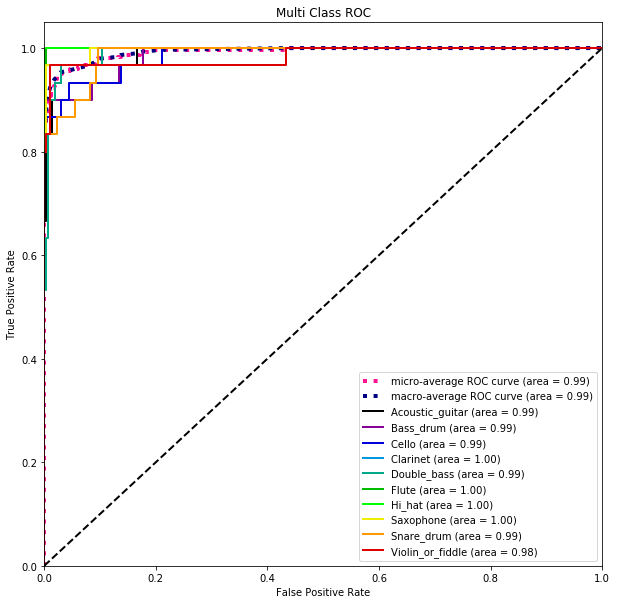

In [6]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = []
cm = pylab.get_cmap('nipy_spectral')
for i in range(n_classes):
    color = cm(1.*i/n_classes)
    colors.append(color)
unique_labels = np.unique(labels)

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (area = {1:0.2f})'.format(unique_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi Class ROC')
legend = plt.legend()
legend._legend_box.align = "right"
plt.legend(loc="lower right")
plt.show()

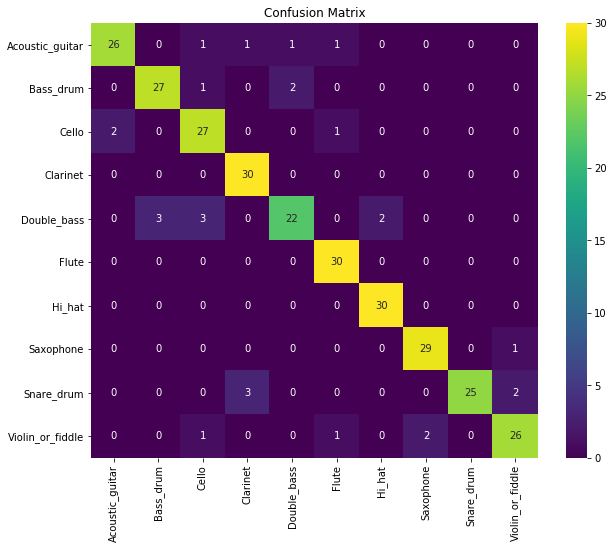

In [7]:
conf_mat = confusion_matrix(y_true_labels, y_pred_labels, labels=unique_labels)
df_cm = pd.DataFrame(conf_mat, index = unique_labels,
                     columns = unique_labels)
plt.figure(figsize = (10,8))
plt.title('Confusion Matrix')
sns.heatmap(df_cm, annot=True, cmap='viridis')
plt.show()